# Connectivity
*Written by Luke Chang*

So far, we have primarily been focusing on analyses related to task evoked brain activity. However, an entirely different way to study the brain is to characterize how it is intrinsically connected. There are many different ways to study functional connectivity. 

The primary division is studying how brain regions are *structurally* connected. In animal studies this might involve directly tracing bundles of neurons that are connected to other neurons. Diffusion imaging is a common way in which we can map how bundles of white matter are connected to each region, based on the direction in which water diffuses along white matter tracks. There are many different techniques such as fractional ansiotropy and probablistic tractography. We will not be discussing structural connectivity in this course.

An alternative approach to studying connectivity is to examine how brain regions covary with each other in time. This is referred to as *functional connectivity*, but it is better to think about it as temporal covariation between regions as this does not necessarily imply that two regions are directly communication with each other.

![mediation.png](../../images/connectivity/mediation.png)

For example, regions can *directly* influence each other, or they can *indirectly* influence each other via a mediating region, or they can be affected similarly by a *shared influence*. These types of figures are often called *graphs*. These types of *graphical* models can be *directed* or *undirected*. Directed graphs imply a causal relationship, where one region A directly influence another region B. Directed graphs or *causal models* are typically described as *effective connectivity*, while undirected graphs in which the relationship is presumed to be bidirectional are what we typically describe as *functional connectivity*.

Here are the videos from [Principles of fMRI](https://www.youtube.com/channel/UC_BIby85hZmcItMrkAlc8eA/featured) that go with this notebook:
- [Brain Connectivity](https://www.youtube.com/watch?v=J0KX_rW0hmc&list=PLfXA4opIOVrEFBitfTGRPppQmgKp7OO-F&index=19)
- [Functional Connectivity](https://www.youtube.com/watch?v=OVAQujut_1o&list=PLfXA4opIOVrEFBitfTGRPppQmgKp7OO-F&index=21&t=0s)
- [Multivariate Decomposition](https://www.youtube.com/watch?v=Klp-8t5GLEg)
- [Effective Connectivity](https://www.youtube.com/watch?v=gv5ENgW0bbs)
- [Graph Theory](https://www.youtube.com/watch?v=v8ls5VED1ng&list=PLfXA4opIOVrEFBitfTGRPppQmgKp7OO-F&index=23&t=0s)

In this notebook, we will work through examples on:
 - Seed-based functional connectivity
 - Psychophysiological interactions
 - Principal Components Analysis
 - Graph Theory

## Functional Connectivity
### Seed Voxel Correlations

One relatively simple way to calculate functional connectivity is to compute the temporal correlation between two regions of interest (ROIs). Typically, this is done by extracting the temporal response from a *seed voxel* or the average response within a *seed region*. Then this time course is regressed against all other voxels in the brain to produce a whole brain map of anywhere that shares a similar time course to the seed.

Let's try it ourselves with an example subject from the Pinel Localizer dataset. First, let's import the modules we need for this tutorial and set our paths.

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map

netid = 'f00275v'
base_dir = '/dartfs/rc/lab/P/Psych60/'
base_dir = '/Volumes/Psych60/'
output_dir = os.path.join(base_dir, 'students_output', netid)
data_dir = os.path.join(base_dir, 'data','brainomics_data')

Now let's load an example participant's preprocessed functional data.

In [4]:
sub = 'S01'
file_name = os.path.join(data_dir, sub ,'preprocessed_fMRI_bold.nii.gz')
data = Brain_Data(file_name)

Next we need to pick an ROI. Pretty much any type of ROI will work. 

In this example, we will be using a whole brain parcellation based on similar patterns of coactivation across over 10,000 published studies available in neurosynth (see this paper for more [details](http://cosanlab.com/static/papers/delaVega_2016_JNeuro.pdf)). We will be using a parcellation of 50 different functionally similar ROIs.

threshold is ignored for simple axial plots


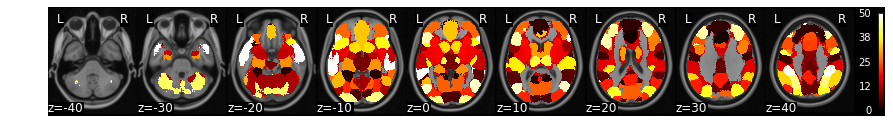

In [3]:
mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'k50_2mm.nii.gz'))

f = mask.plot()

Each ROI in this parcellation has its own unique number. We can expand this so that each ROI becomes its own binary mask using `nltools.mask.expand_mask`.

Let's plot the first 5 masks.

threshold is ignored for simple axial plots


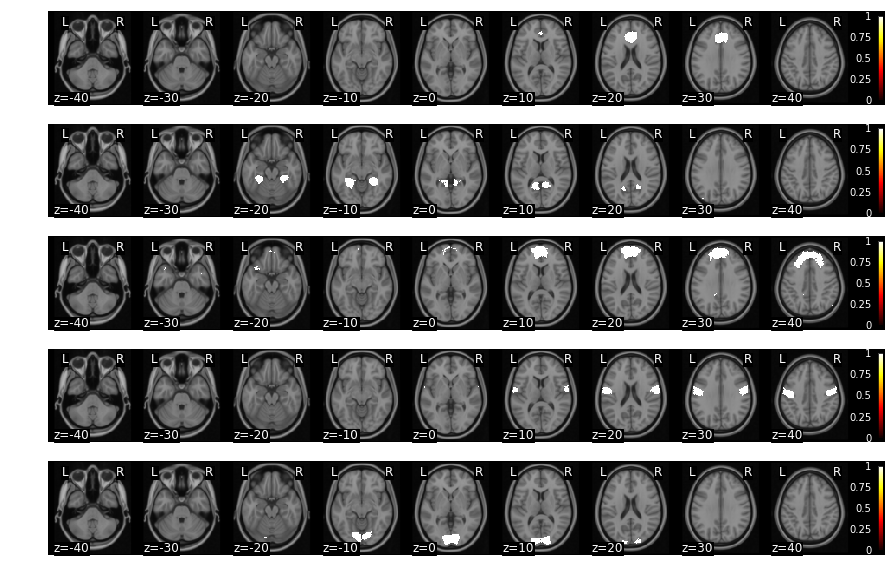

In [6]:
mask_x = expand_mask(mask)

f = mask_x[0:5].plot()

To use any mask we just need to index it by the correct label.

Let's start by using the vmPFC mask (ROI=32) to use as a seed in a functional connectivity analysis.

Text(0.5, 0, 'Time (TRs)')

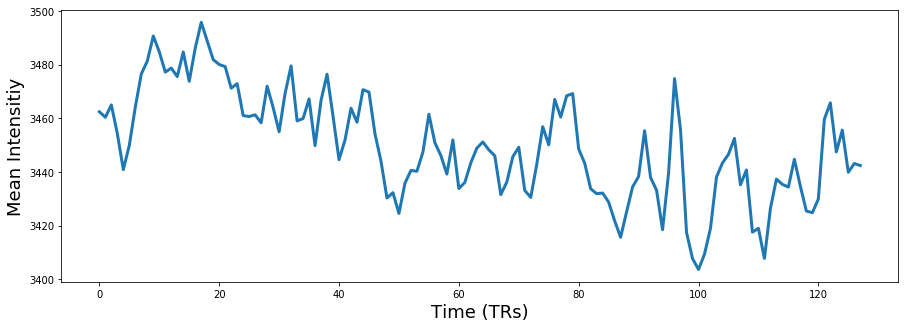

In [73]:
vmpfc = data.extract_roi(mask=mask_x[32])

plt.figure(figsize=(15,5))
plt.plot(vmpfc, linewidth=3)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

Okay, now let's build our regression design matrix to perform the whole-brain functional connectivity analysis.

The goal is to find which regions in the brain have a similar time course to the vmPFC, controlling for all of our covariates (i.e., nuisance regressors).

Functional connectivity analyses are particularly sensitive to artifacts that might induce a temporal relationship, particularly head motion (See this [article](https://www.sciencedirect.com/science/article/pii/S1053811911011815) by Jonathan Power for more details). This means that we will need to use slightly different steps to preprocess data for this type of analyis then a typical event related mass univariate analysis. 

We are going to remove the mean from our vmPFC signal. We are also going to include the average activity in CSF as an additional nuisance regressor to remove physiological artifacts. Finally, we will be including our 24 motion covariates as well as linear and quadratic trends. We need to be a little careful about filtering as the normal high pass filter for an event related design might be too short and will remove potential signals of interest.

Resting state researchers also often remove the global signal, which can reduce physiological and motion related artifacts and also increase the likelihood of observing negative relationships with your seed regressor (i.e., anticorrelated). This procedure has remained quite controversial in practice (see [here](https://www.physiology.org/doi/full/10.1152/jn.90777.2008) [here](https://www.sciencedirect.com/science/article/pii/S1053811908010264), [here](https://www.pnas.org/content/107/22/10238.short), and [here](https://www.sciencedirect.com/science/article/pii/S1053811916306711) for a more in depth discussion). We think that in general including covariates like CSF should be sufficient. It is also common to additionally include covariates from white matter masks, and also multiple principal components of this signal rather than just the mean (see more details about [compcorr](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2214855/).

Overall, this code should seem very familiar as it is pretty much the same procedure we used in the single subject GLM tutorial. However, instead of modeling the task design, we are interested in calculating the functional connectivity with the vmPFC.

In [320]:
tr = 2.4
fwhm = 6
n_tr = len(data)

def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

vmpfc = zscore(pd.DataFrame(vmpfc, columns=['vmpfc']))

csf_mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'csf.nii.gz'))
csf = zscore(pd.DataFrame(data.extract_roi(mask=csf_mask).T, columns=['csf']))

spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
mc = pd.read_csv(os.path.join(data_dir, sub ,'realignment_parameters.txt'), sep='\s', header=None)
mc_cov = make_motion_covariates(mc, tr)
dm = Design_Matrix(pd.concat([vmpfc, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)

data.X = dm
stats = data.regress()

smoothed = stats['beta'].smooth(fwhm=fwhm)
vmpfc_conn = smoothed[0]

/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: Runti

threshold is ignored for simple axial plots


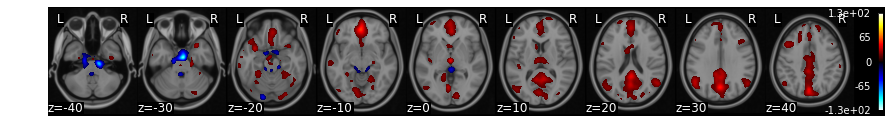

In [69]:
f = vmpfc_conn.threshold(upper=15, lower=-15).plot()

Notice how this analysis identifies the default network? This analysis is very similar to the [original papers](https://www.pnas.org/content/102/27/9673/) that identified the default mode network using resting state data.

For an actual analysis, we would need to repeat this procedure over all of the participants in our sample and then perform a second level group analysis to identify which voxels are consistently coactive with the vmPFC. We will explore group level analyses in the exercises.

### Psychophysiological Interactions

Suppose we were interested in seeing if the vmPFC was connected to other regions differently when performing a finger tapping task compared to all other conditions. To compute this analysis, we will need to create a new design matrix that combines the motor regressors and then calculates an interaction term between the seed region activity (e.g., vmpfc) and the condition of interest (e.g., motor).

This type of analysis called, *psychophysiological* interactions was originally [proposed](https://www.fil.ion.ucl.ac.uk/spm/doc/papers/karl_ppi.pdf) by Friston et al., 1997. For a more hands on and practical discussion read this [paper](https://pdfs.semanticscholar.org/dd86/1acdb332ea7fa9de8fb677a4048651eaea02.pdf) and watch this [video](https://www.youtube.com/watch?v=L3iBhfEYEgE) by Jeanette Mumford and a follow up [video](https://www.youtube.com/watch?v=M8APlF6oBgA)) of a more generalized method.


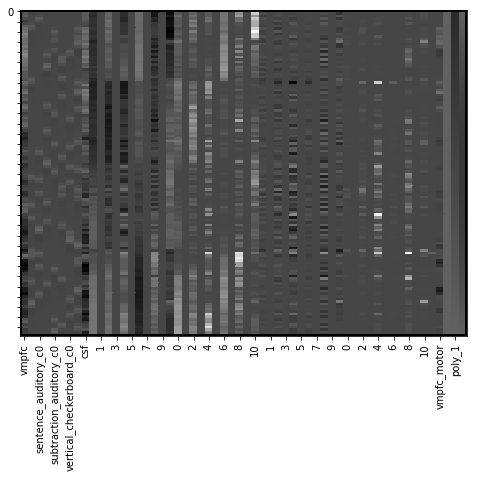

In [332]:
motor_variables = ['motor_left_auditory','motor_left_visual', 'motor_right_auditory', 'motor_right_visual']
df = pd.read_csv(os.path.join(data_dir, 'Design_Matrix.csv'))
dm = Design_Matrix(df, sampling_freq=1/tr)
dm = dm.loc[:n_tr-1,:]
ppi_dm = dm.drop(motor_variables, axis=1)
ppi_dm['motor'] = pd.Series(dm.loc[:,motor_variables].sum(axis=1))
ppi_dm_conv = ppi_dm.convolve()
dm = Design_Matrix(pd.concat([vmpfc, ppi_dm_conv, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm['vmpfc_motor'] = dm['vmpfc']*dm['motor_c0']
dm = dm.add_poly(order=2, include_lower=True)

dm.heatmap()

Okay, now we are ready to run the regression analysis and inspect the interaction term to find regions where the connectivity profile changes as a function of the motor task.

We will run the regression and smooth all of the images, and then examine the beta image for the PPI interaction term.

/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/

threshold is ignored for simple axial plots


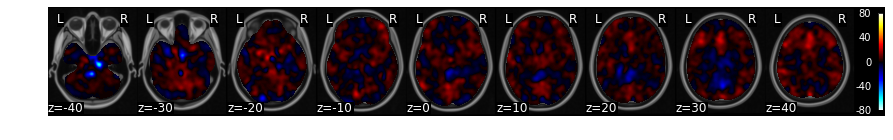

In [396]:
data.X = dm
ppi_stats = data.regress()

smoothed = ppi_stats['beta'].smooth(fwhm=fwhm)

vmpfc_motor_ppi = smoothed[int(np.where(data.X.columns=='vmpfc_motor')[0][0])]

f = vmpfc_motor_ppi.plot()

This analysis tells us which regions are more functionally connected with the vmPFC during the motor conditions relative to the rest of experiment.

We can make a thresholded interactive plot to interrogate these results, but it looks like it identifies the ACC/pre-SMA.

In [395]:
vmpfc_motor_ppi.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

### Dynamic Connectivity

All of the methods we have discussed so far assume that the relationship between two regions is stationary - or remains constant over the entire dataset. However, it is possible that voxels are connected to other voxels at specific points in time, but then change how they are connected when they are computing a different function or in different psychological state.

Time-varying connectivity is beyond the scope of the current tutorial, but we encourage you to watch this [video](https://www.youtube.com/watch?v=lV9thGD18JI&list=PLfXA4opIOVrEFBitfTGRPppQmgKp7OO-F&index=22&t=0s) from Principles of fMRI for more details

## Effective Connectivity
Effective connectivity refers to the degree that one brain region has a directed influence on another region. This approach requires making a number of assumptions about the data and requires testing how well a particular model describes the data. Typically, most researchers will create a model of a small number of nodes and compare different models to each other. This is because the overall model fit is typically in itself uninterpretable and because formulating large models can be quite difficult and computationally expensive. The number of connections can be calculated as:

$connections = \frac{n(n-1)}{2}$, where $n$ is the total number of nodes.

### Structural Equation Modeling

Structural equation modeling (SEM) is one early techniques that was used to model the causal relationship between multiple nodes. SEM requires specifying a specific causal relationship between nodes in terms of a set of linear equations. The parameters of this system of equations reflects the connectivity matrix. Users are expected to formulate their own hypothesized relationship between variables with a value of one when there is an expected relationship, and zero when there is no relationship. Then we estimate the parameters of the model and evaluate how well the model describes the observed data.

![sem.png](../../images/connectivity/sem.png)

We will not be discussing this method in much detail. In practice, this method is more routinely used to examine how brain activations mediate relationships between other regions, or between different psychological constructs (e.g., X -> Z -> Y). 

Here are a couple of videos specifically examining how to conduct mediation and moderation analyses from Principles of fMRI ([Mediation and Moderation Part I](https://www.youtube.com/watch?v=0YqWXIfpu20), 
[Mediation and Moderation Part II](https://www.youtube.com/watch?v=0YqWXIfpu20))

### Granger Causality
Granger causality was originally developed in econometrics and is used to determine temporal causality. The idea is to quantify how past values of one brain region predict the current value of another brain region. This analysis can also be performed in the frequency domain using measures of coherence between two regions. In general, this technique is rarely used in fMRI data analysis as it requires making assumptions that all regions have the same hemodynamic response function (which does not seem to be true), and that the relationship is stationary, or not varying over time.

Here is a [video](https://www.youtube.com/watch?v=yE9aBHQ7bnA) from Principles of fMRI explaining Granger Causality in more detail.

### Dynamic Causal Modeling

Dynamic Causal Modeling (DCM) is a method specifically developed for conducting causal analyses between regions of the brain for fMRI data. The key innovation is that the developers of this method have specified a generative model for how neuronal firing will be reflected in observed BOLD activity. This addresess one of the problems with SEM, which assumes that each ROI has the same hemodynamic response. 

In practice, DCM is computationally expensive to estimate and researchers typically specify a couple small models and perform a model comparison (e.g., bayesian model comparison) to determine, which model best explains the data from a set of proposed models.

Here is a [video](https://www.youtube.com/watch?v=JoJKoq5gmH8) from Principles of fMRI explaining Dynamic Causal Modeling in more detail.

## Multivariate Decomposition

So far we have discussed functional connectivity in terms of pairs of regions. However, voxels are most likely not independent from each other and we may want to figure out some latent spatial components that are all functionally connected with each (i.e., covary similarly in time).

To do this type of analyis, we typically use what are called *multivariate decomposition* methods, which attempt to factorize a data set (i.e., time by voxels) into a lower dimensional set of components, where each has their own unique time course.

The most common decomposition methods or Principal Components Analysis (PCA) and Independent Components Analysis (ICA).

### Principal Components Analysis
Principal Components Analysis (PCA) is a multivariate procedure that attempts to explain the variance-covariance structure of a high dimensional random vector. In this procedure, a set of correlated variables are transformed int a set of uncorrelated variables, ordered by the amount of variance in the data that they explain.

In fMRI, we use PCA to find spatial maps or *eigenimages* in the data. This is usually computed using Singular Value Decomposition (SVD). This operation is defined as:

$X = USV^T$, where $V^T V = I$, $U^T U = I$, and $S$ is a diagonal matrix whose elements are called singular values. 

In practice, $V$ corresponds to the eigenimages or spatial components and $U$ corresponds to the transformation matrix to convert the eigenimages into a timecourse. $S$ reflects the amount of scaling for each component.

![svd.png](../../images/connectivity/svd.png)

SVD is conceptually very similar to regression. We are trying to explain a matrix $X$ as a linear combination of components. Each term in the equation reflects a unique (i.e., orthogonal) multivariate signal present in $X$. For example, the $nth$ signal in X can be described by the dot product of a time course $u_n$ and the spatial map $Vn^T$  scaled by $s_n$. 

$X = s_1 u_1 v_1^T + s_2 u_2 v_2^T + s_n u_n v_n^T$

Let's try running a PCA on our single subject data. To do this, we will use the `.decompose()` method from nltools. All we need to do is specify the algorithm we want to use, the dimension we want to reduce (i.e., time - 'images' or space 'voxels'), and the number of components to estimate. Usually, we will be looking at reducing space based on similarity in time, so we will set `axis='images'`.

In [281]:
n_components = 10

pca_stats_output = smoothed_denoised.decompose(algorithm='pca', axis='images',
                                n_components=n_components)

/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


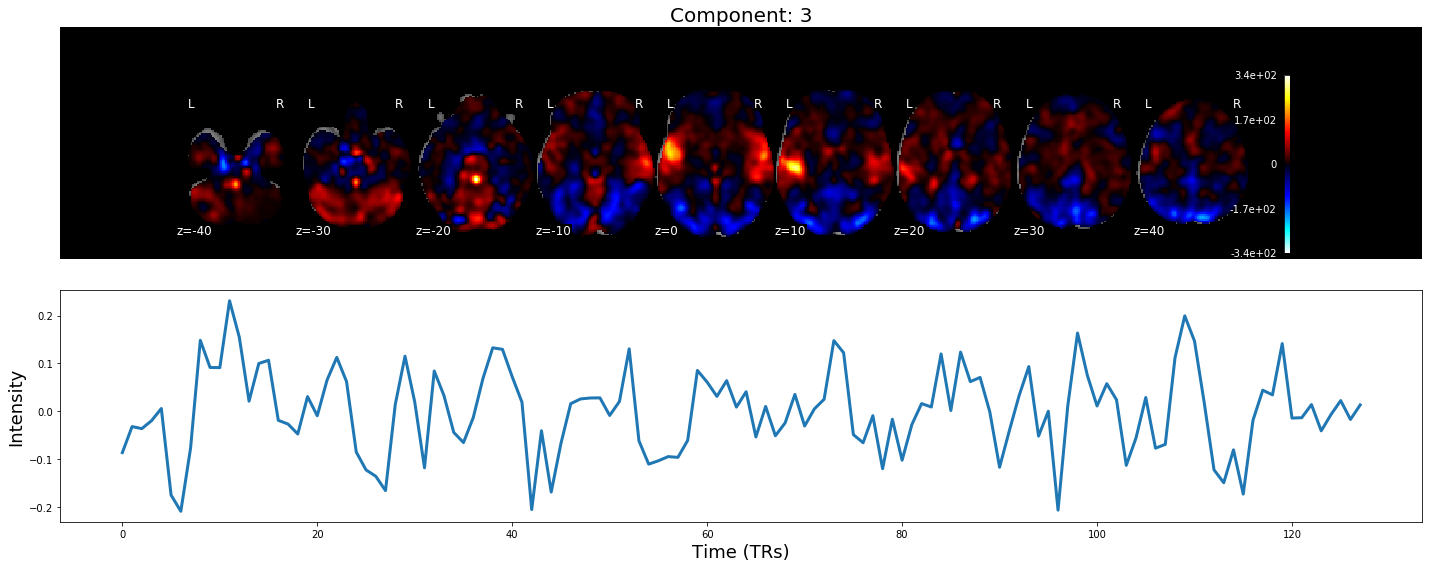

In [282]:
def plot_decomposition_output(stats_output, component):
    '''Generate plots from decompose output'''
    f,a = plt.subplots(nrows=2, figsize = (20,8))
    plot_stat_map(stats_output['components'][component].to_nifti(), 
                  cut_coords=range(-40, 50, 10), display_mode='z',
                  black_bg=True, colorbar=True, draw_cross=False, axes=a[0])
    a[1].plot(stats_output['weights'][:, component], linewidth=3)
    a[1].set_xlabel('Time (TRs)', fontsize=18)
    a[1].set_ylabel('Intensity', fontsize=18)
    a[0].set_title(f'Component: {component}', fontsize=20)
    plt.tight_layout()


plot_decomposition_output(pca_stats_output, 3)

We can also examine the eigenvalues/singular values or scaling factor of each, which are the diagonals of $S$.

These values are stored in the `'decomposition_object'` of the stats_output and are in the variable called `.singular_values_`.

Text(0, 0.5, 'Singular Values')

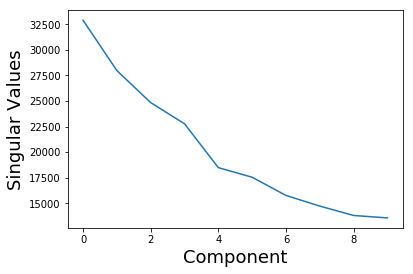

In [379]:
plt.plot(pca_stats_output['decomposition_object'].singular_values_)
plt.xlabel('Component', fontsize=18)
plt.ylabel('Singular Values', fontsize=18)

We can use these values to calculate the overall variance explained by each component. These values are stored in the `'decomposition_object'` of the stats_output and are in the variable called `.explained_variance_ratio_`.

These values can be used to create what is called a *scree* plot to figure out the percent variance of $X$ explained by each component. Remember, in PCA, components are ordered by descending variance explained.

Text(0.5, 1.0, 'Cumulative Variance Explained')

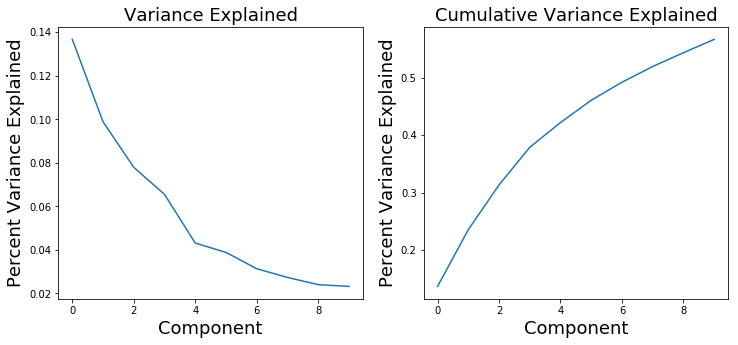

In [366]:
f,a = plt.subplots(ncols=2, figsize=(12, 5))
a[0].plot(pca_stats_output['decomposition_object'].explained_variance_ratio_)
a[0].set_ylabel('Percent Variance Explained', fontsize=18)
a[0].set_xlabel('Component', fontsize=18)
a[0].set_title('Variance Explained', fontsize=18)
a[1].plot(np.cumsum(pca_stats_output['decomposition_object'].explained_variance_ratio_))
a[1].set_ylabel('Percent Variance Explained', fontsize=18)
a[1].set_xlabel('Component', fontsize=18)
a[1].set_title('Cumulative Variance Explained', fontsize=18)

### Independent Components Analysis

Independent Components Analysis (ICA) is a method to blindly separate a source signal into spatially independent components. This approach assumes that the data consts of $p$ spatially independent components, which are linearly mixed and spatially fixed. PCA assumes orthonormality constraint, while ICA only assumes independence.

$X = AS$, where $A$ is the *mixing matrix* and $S$ is the *source matrix*

In ICA we find an un-mixing matrix $W$, such that $Y = WX$ provides an approximation to $S$. To estimate the mixing matrix, ICA assumes that the sources are (1) linearly mixed, (2) the components are statistically independent, and (3) the components are non-Gaussian.

It is trivial to run ICA on our data as it only requires switching `algorithm='pca'` to `algorithm='ica'` when using the `decompose()` method.

We will experiment with this in our exercises.

## Graph Theory

Similar to describing the structure of social networks, graph theory has also been used to characterize regions of the brain based on how they connected to other regions. Node in the network typically describe specific brain regions and edges represent the strength of the association between each edge. That is, the network can be represented as a graph of pairwise relationships between each region of the brain.

There are many different metrics of graphs that can be used to describe the overall efficiency of a network (e.g., small worldness), or how connected a region is to other regions (e.g., degree, centrality), or how long it would take to send information from one node to another node (e.g., path length, connectivity).

![graph.png](../../images/connectivity/graph.png)

Suppose, we were interested in identifying which regions of the brain had the highest degree of centrality based on functional connectivity. There are many different ways to do this, but they all involve specifying a set of nodes (i.e., ROIs) and calculating the edges between each node. Finally, we would need to pick a centrality metric and calculate the overall level of centrality for each region.

Let's do this quickly building off of our seed-based functional connectivity analysis.

First, let's denoise the data using our nuisance regressors and then extract the average time course from each ROI in our whole-brain parcellation. This is essentially identical to the vmPFC analysis, except that we will not be including any seed regressors. We will then be working with the residual of our regression, which is the remaining signal after removing any variance associated with our covariates.

In [79]:
tr = 2.4
fwhm = 6
n_tr = len(data)

def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

csf_mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'csf.nii.gz'))
csf = zscore(pd.DataFrame(data.extract_roi(mask=csf_mask).T, columns=['csf']))

spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
mc = pd.read_csv(os.path.join(data_dir, sub ,'realignment_parameters.txt'), sep='\s', header=None)
mc_cov = make_motion_covariates(mc, tr)
dm = Design_Matrix(pd.concat([csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)

data.X = dm
stats = data.regress()

smoothed_denoised = stats['residual'].smooth(fwhm=fwhm)

/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:970: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/nltools/stats.py:979: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/

Next, we will extract the average time course within each ROI from our 50 parcels and plot the results.

Text(0.5, 0, 'Time (TRs)')

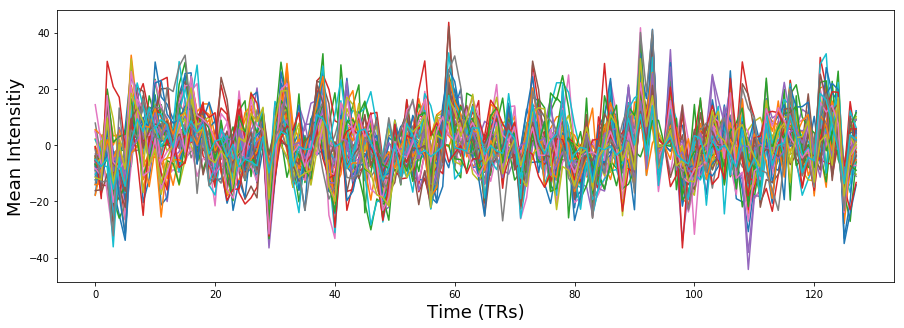

In [87]:
rois = smoothed_denoised.extract_roi(mask=mask)

plt.figure(figsize=(15,5))
plt.plot(rois.T)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

Now that we have specified our 50 nodes, we need to calculate the edges of the graph. We will be using pearson correlations. We will be using the `pairwise_distances` function from scikit-learn as it is much faster than most other correlation measures. We will then convert the distance metric into similarities by subtracting all of the values from 1.

Let's visualize the resulting correlation matrix as a heatmap using seaborn.

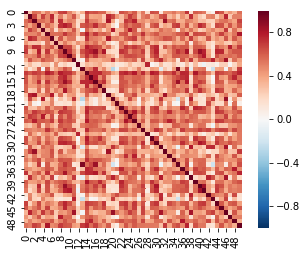

In [295]:
roi_corr = 1 - pairwise_distances(rois, metric='correlation')

sns.heatmap(roi_corr, square=True, vmin=-1, vmax=1, cmap='RdBu_r')

Now we need to convert this correlation matrix into a graph and calculate a centrality measure. We will use the `Adjacency` class from nltools as it has many functions that are useful for working with this type of data, including casting these type of matrices into networkx graph objects.

We will be using the [networkx](https://networkx.github.io/documentation/stable/) python toolbox to work with graphs and compute different metrics of the graph.

Let's calculate degree centrality, which is the total number of nodes each node is connected with. Unfortunately, many graph theory metrics require working with adjacency matrices, which are binary matrices indicating the presence of an edge or not. To create this, we will simply apply an arbitrary threshold to our correlation matrix.

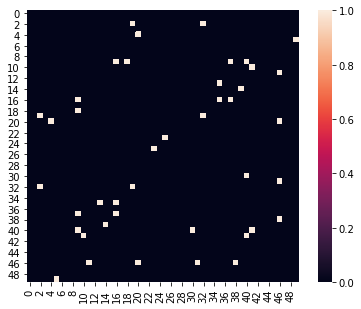

In [191]:
a = Adjacency(roi_corr, matrix_type='similarity')
a_thresholded = a.threshold(upper=.8, binarize=True)

f = a_thresholded.plot()

Okay, now that we have a thresholded binary matrix, let's cast our data into a networkx object and calculate the degree centrality of each ROI and make a quick plot of the graph.

/Users/lukechang/anaconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


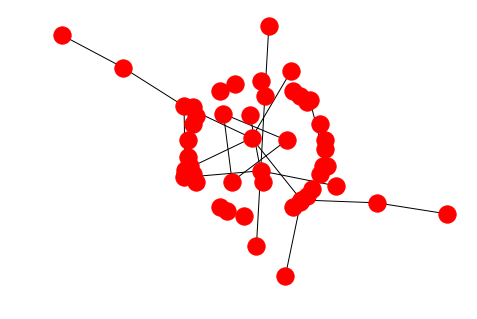

In [192]:
g = a_thresholded.to_graph()

nx.draw_kamada_kawai(g)

We can also plot the distribution of degree using this threshold.

Text(0.5, 0, 'Degree')

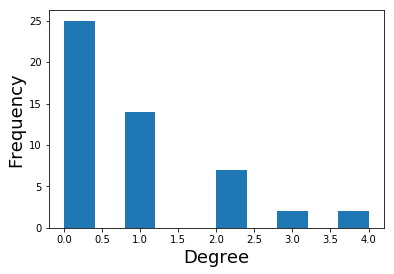

In [193]:
plt.hist(dict(g.degree).values())
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Degree', fontsize=18)

What if we wanted to map the degree of each node back onto the brain?

This would allow us to visualize which of the parcels had more direct pairwise connections.

To do this, we will simply scale our expanded binary mask object by the node degree. We will then combine the masks by concatenating through recasting as a brain_data object and then summing across all ROIs.

threshold is ignored for simple axial plots


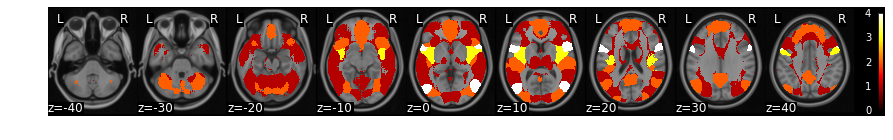

In [194]:
degree = pd.Series(dict(g.degree()))
degree = Brain_Data([mask_x[x]*float(degree[x]) for x in degree.keys()]).sum()
f = degree.plot()

This analysis shows that the insula is one of the regions that appears to have the highest degree in this analysis. This is a fairly classic [finding](https://link.springer.com/article/10.1007/s00429-010-0262-0) with the insula frequently found to be highly connected with other regions. Of course, we are only looking at one subject in a very short task (and selecting a completely arbitrary cutoff). We would need to show this survives correction after performing a group analysis.

## Exercises

Let's practice what we learned through a few different exercises.

### 1) Let's calculate seed-based functional connectivity using a different ROI - the right motor cortex

- Calculate functional connectivity using roi=48 with the whole brain.

### 2) Calculate a group level analysis for this connectivity analysis
- this will require running this analysis over all subjects
- then running a one sample t-test
- then correcting for multiple tests with fdr.

### 3) Calculate an ICA
- run an ICA analysis for subject01 with 5 components
- plot each spatial component and its associated timecourse

### 4) Calculate Eigenvector Centrality for each Region
- figure out how to calculate eigenvector centrality and compute it for each region.

### 5) Calculate a group level analysis for this graph theoretic analysis
- this will require running this analysis over all subjects
- then running a one sample t-test
- then correcting for multiple tests with fdr.